##### 数据构成
总共 100,000 条评论，其中包括：

- 25,000 条标注的训练集（train/）

- 25,000 条标注的测试集（test/）

- 50,000 条无标注的评论（train/unsup/）

imdb.vocab : 官方给出的词汇表，一行一词，

##### 标签定义

评分 ≤ 4 的评论标为 负面（neg），评分 ≥ 7 的评论标为 正面（pos）。中性评分（5-6 分）被排除在标注数据之外


Epoch 1 | Train Loss: 0.5835, Acc: 0.6865 | Test Loss:  0.5435, Acc: 0.7300
Epoch 2 | Train Loss: 0.4252, Acc: 0.8074 | Test Loss:  0.4170, Acc: 0.8124
Epoch 3 | Train Loss: 0.3266, Acc: 0.8629 | Test Loss:  0.3880, Acc: 0.8353
Epoch 4 | Train Loss: 0.2527, Acc: 0.8983 | Test Loss:  0.3897, Acc: 0.8363
Epoch 5 | Train Loss: 0.1858, Acc: 0.9297 | Test Loss:  0.4198, Acc: 0.8343


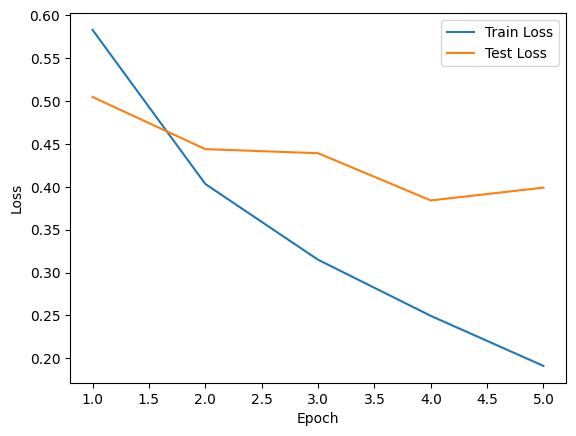

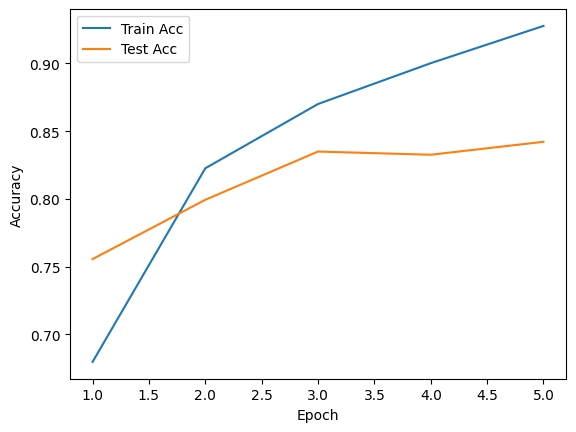

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

DATA_DIR   = './data_循环'
VOCAB_FILE = os.path.join(DATA_DIR, 'imdb.vocab')

# 字典
vocab_list = []
with open(VOCAB_FILE, 'r', encoding='utf-8') as vf:
    for line in vf:
        tok = line.strip()
        if tok:
            vocab_list.append(tok)

# 构建 单词与索引映射，0 留作 <pad>
word2idx = {w:i+1 for i,w in enumerate(vocab_list)}
vocab_size = len(word2idx) + 2  # +1 留给 pad, +1 留给 unk
pad_idx    = 0
unk_idx    = len(word2idx) + 1

# 分词
def tokenizer(text):
    return text.split()

# 过滤掉不在字典中的词
def filter_tokens(tokens):
    return [tok for tok in tokens if tok in word2idx]

class IndexDataset(Dataset):
    def __init__(self, directory):
        self.samples = [] # [(text, label)]
        for label in ['pos','neg']:
            path = os.path.join(directory, label)
            for fname in os.listdir(path):
                if not fname.endswith('.txt'): continue
                text = open(os.path.join(path,fname), 'r', encoding='utf-8').read()
                self.samples.append((text, 1 if label=='pos' else 0))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text, y = self.samples[idx]
        toks = filter_tokens(tokenizer(text))
        if len(toks) == 0:
            idxs = [unk_idx]
        else:
            idxs = [word2idx.get(tok, unk_idx) for tok in toks]
        return torch.tensor(idxs, dtype=torch.long), torch.tensor(y, dtype=torch.float32)

def collate_batch(batch):
    idx_seqs, labels = zip(*batch)
    lengths = torch.tensor([len(s) for s in idx_seqs], dtype=torch.long)
    padded  = nn.utils.rnn.pad_sequence(
        idx_seqs, batch_first=True, padding_value=pad_idx
    ) # 长度根据批次内容动态调整
    labels  = torch.stack(labels)
    return padded, lengths, labels

class EmbeddingBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_idx=0, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm      = nn.LSTM(embed_dim, hidden_dim,
                                 bidirectional=True, batch_first=True)
        self.fc        = nn.Linear(hidden_dim*2, num_classes)
        self.sigmoid   = nn.Sigmoid()

    def forward(self, x, lengths):
        # x: [B, L]
        emb = self.embedding(x)  # [B, L, embed_dim]
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        ) # 序列按照真实长度 “打包” 成一个 PackedSequence，在计算时忽略padding
        _, (hidden, _) = self.lstm(packed)
        h_fwd = hidden[-2]  # 正向最后一层
        h_bwd = hidden[-1]  # 反向最后一层
        h = torch.cat([h_fwd, h_bwd], dim=1)  # [B, hidden_dim*2]
        return self.sigmoid(self.fc(h)).squeeze()

BATCH_SIZE = 32
EMBED_DIM  = 64
HIDDEN_DIM = 64
EPOCHS     = 5
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ds = IndexDataset(os.path.join(DATA_DIR,'train')) # [text, 标签]
test_ds  = IndexDataset(os.path.join(DATA_DIR,'test'))
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_batch)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE,
                          collate_fn=collate_batch)

model     = EmbeddingBiLSTM(vocab_size, EMBED_DIM, HIDDEN_DIM, pad_idx).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

def binary_accuracy(preds, y):
    return ((preds>=0.5).float()==y).float().mean()

train_losses_list, test_losses_list = [], []
train_accs_list,   test_accs_list   = [], []

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss, total_acc = 0, 0
    for x, lengths, y in train_loader: # X:批次所有向量 lengths：每个向量长度 y:标签
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x, lengths)
        loss  = criterion(preds, y)
        acc   = binary_accuracy(preds, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # 梯度裁剪
        optimizer.step()
        total_loss += loss.item()
        total_acc  += acc.item()
    train_loss = total_loss / len(train_loader)
    train_acc  = total_acc  / len(train_loader)

    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for x, lengths, y in test_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            preds = model(x, lengths)
            loss  = criterion(preds, y)
            acc   = binary_accuracy(preds, y)
            total_loss += loss.item()
            total_acc  += acc.item()
    test_loss = total_loss / len(test_loader)
    test_acc  = total_acc  / len(test_loader)
    train_losses_list.append(train_loss)
    test_losses_list.append(test_loss)
    train_accs_list.append(train_acc)
    test_accs_list.append(test_acc)
    print(f"Epoch {epoch} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Test Loss:  {test_loss:.4f}, Acc: {test_acc:.4f}")

plt.figure()
plt.plot(range(1,EPOCHS+1), train_losses_list, label='Train Loss')
plt.plot(range(1,EPOCHS+1), test_losses_list,  label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1,EPOCHS+1), train_accs_list, label='Train Acc')
plt.plot(range(1,EPOCHS+1), test_accs_list,  label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
